# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create sbml model from scratch
!./createSteadystateExampleSBML.py > model_steadystate_scaled.sbml

In [3]:
sbml_file = 'model_steadystate_scaled.sbml'
model_name = 'model_steadystate_scaled'
model_output_dir= 'model_steadystate_scaled'

In [4]:
# Show model info
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('Parameters: ', [p.getId() for p in sbml_model.getListOfParameters()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['x1', 'x2', 'x3']
Parameters:  ['p1', 'p2', 'p3', 'p4', 'p5', 'k0', 'observable_x1', 'observable_x2', 'observable_x3', 'scaling_x1', 'observable_x1_scaled', 'offset_x2', 'observable_x2_offsetted', 'observable_x1withsigma_sigma', 'observable_x1withsigma']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


## Generate model code

In [5]:
observables = []
fixed_parameters = ['k0']

def createModule(sbml_model_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_model_file)
    sbml = sbmlImporter.sbml
    global observables
    observables = amici.assignmentRules2observables(sbml, filter=lambda variableId: 
                                                    variableId.startswith('observable_') and not variableId.endswith('_sigma'))
    
    print(observables)
    print(fixed_parameters)

    sbmlImporter.sbml2amici(model_name,
                            output_dir=model_output_dir,
                            observables=observables,
                            constantParameters=fixed_parameters,
                            sigmas={'observable_x1withsigma': 'observable_x1withsigma_sigma'})


createModule(sbml_file, model_name, model_output_dir)



{'observable_x1': 'x1', 'observable_x2': 'x2', 'observable_x3': 'x3', 'observable_x1_scaled': 'scaling_x1 * x1', 'observable_x2_offsetted': 'offset_x2 + x2', 'observable_x1withsigma': 'x1'}
['k0']


## Test simulation

In [6]:
def plotStateTrajectories(rdata):
    for ix in range(rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


[1.  0.5 0.4 2.  0.1 2.  3.  0.2]
{'t': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]), 'x': array([[0.1000178 , 0.4000123 , 0.6999792 ],
       [0.10003683, 0.40002545, 0.69995696],
       [0.1000762 , 0.40005266, 0.69991096],
       [0.10015767, 0.40010894, 0.69981577],
       [0.1003262 , 0.40022538, 0.69961885],
       [0.10067479, 0.40046616, 0.6992116 ],
       [0.10139555, 0.4009638 , 0.69836975],
       [0.10288464, 0.40199105, 0.69663131],
       [0.10595616, 0.4041061 , 0.69304903],
       [0.11227026, 0.40843807, 0.6856998 ],
       [0.12515789, 0.41721488, 0.6707597 ],
       [0.15106393, 0.43460508, 0.64095895],
       [0.20141095, 0.46753068, 0.58381562],
       [0.291

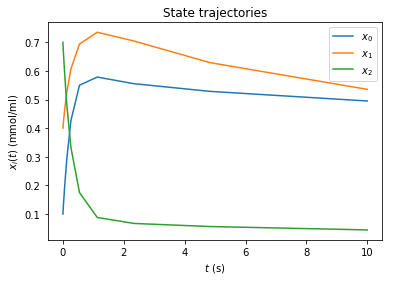

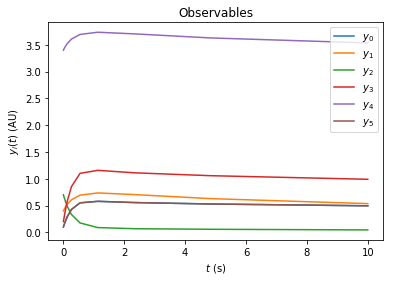

In [7]:
# load model
sys.path.insert(0, model_output_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [8]:
expectedLlh = 0.0
sigma_default = 0.1 # parameters are lin
sigma_parameter = 0.2
offset_batch_1 = 3.0
offset_batch_2 = 4.0
offsetted_observable_idx = 4
sigma_parameter_observable_idx = 5
model_offset_parameter_idx = 6
sigma_parameter_idx = 7
timepoints = np.logspace(-5, 1, 20)

model = modelModule.getModel()
default_parameters = np.array(model.getParameters())
default_parameters[sigma_parameter_idx] = sigma_parameter
true_parameters = default_parameters
true_parameters = np.append(true_parameters, offset_batch_2) # add second offset parameter
print('true_parameters: %s' % true_parameters)

def createData():
    # setup model & solver
    model = modelModule.getModel()
    model.setTimepoints(amici.DoubleVector(timepoints))
    model.setParameters(amici.DoubleVector(default_parameters))
    print('Default parameters: ', default_parameters)
    
    solver = model.getSolver()
    solver.setMaxSteps(10000)

    # generate conditon-vectors
    conditions = [np.array(model.getFixedParameters())]
    conditions.append(conditions[0] * 1.1)
    conditions.append(conditions[0] * 1.2)
    conditions.append(conditions[0] * 1.3)

    conditionDf = createConditionDataframe(fixed_parameters, conditions)
    
    df = pd.DataFrame(data={
        'observable': [],
        'condition': [],
        'conditionRef': [],
        'scalingParameter': [],
        'time': [],
        'measurement': [],
        'sigma': []
    })

    global expectedLlh
    for icondition, condition in enumerate(conditions):      
        print('Condition %d: %s' % (icondition, condition))
        
        # different offset for two "batches"
        batch_id = icondition % 2
        if batch_id == 0:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_1
        else:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_2
        
        sigmay = np.ones(shape=(model.nt(), model.nytrue)) * sigma_default
        sigmay[:, sigma_parameter_observable_idx] = np.nan # observable with sigma parameter
        
        # simulate condition
        rdata = getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay)
        
        print('\tllh: ', rdata['llh'])
        print('\tsllh', rdata['sllh'])

        expectedLlh += rdata['llh']
        
        conditionName = 'condition-%d' % icondition
        
        # Append data
        for iy, observableName in enumerate(observables.keys()):
            scalingParameter = [''] 
            sigma = sigmay[:, iy]
            
            if observableName == 'observable_x1_scaled':
                #scalingParameter = ['scaling_x1_%s' % conditionName]
                scalingParameter = ['scaling_x1_common']
            elif observableName == 'observable_x2_offsetted':
                #scalingParameter = ['offset_x2_%s' % conditionName]
                #scalingParameter = ['offset_x2_common']
                scalingParameter = ['offset_x2_batch-%d' % batch_id]
            elif observableName == 'observable_x1withsigma':
                #scalingParameter = ['observable_x1withsigma_sigma_%s' % conditionName]
                scalingParameter = ['observable_x1withsigma_sigma_common']
            
            df = df.append(pd.DataFrame(
            {'observable'      : [observableName] * model.nt(),
             'condition'       : [conditionName]  * model.nt(),
             'conditionRef'    : ['']  * model.nt(),
             'scalingParameter': scalingParameter * model.nt(),
             'time'            : np.array(model.getTimepoints()),
             'measurement'     : rdata['y'][:, iy],
             'sigma'           : sigma
             }), ignore_index=True)
    print('Expected llh: ', expectedLlh)
            
    return df, conditionDf


def createConditionDataframe(fixed_parameters, conditions):
    """Create dataframe with fixed-parameters for each condition to simulate"""
    conditionDf = pd.DataFrame(index = fixed_parameters)
    conditionDf['ID'] = conditionDf.index
    for icondition, condition in enumerate(conditions):
        conditionDf['condition-%d' % icondition] = condition
    
    return conditionDf


def getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay):
    model.setParameters(amici.DoubleVector(simulationParameters))
    
    # simulate without measurements
    edata = amici.ExpData(model.get())
    edata.fixedParameters = amici.DoubleVector(condition)
    edata.my = amici.DoubleVector(np.full(shape=model.nt() * model.nytrue, fill_value=np.nan))
    rdata = amici.runAmiciSimulation(model, solver, edata)        
    # fixedParametersPreequilibration = 

    # confirm gradient is 0 for real measurements and save expected llh
    measurement = rdata['y']
    #measurement = np.random.normal(loc=rdata['y'], scale=np.sqrt(sigmay))
    print((measurement-rdata['y'])/rdata['y'])
    #measurement[:, sigma_parameter_observable_idx] = np.random.normal(
    #    loc=rdata['y'][:, sigma_parameter_observable_idx], 
    #    scale=np.sqrt(simulationParameters[sigma_parameter_idx]))

    edata.my = amici.DoubleVector(measurement.flatten())
    edata.sigmay = amici.DoubleVector(sigmay.flatten())
    solver.setSensitivityMethod(amici.AMICI_SENSI_FSA)
    solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)
    model.requireSensitivitiesForAllParameters()
    rdata = amici.runAmiciSimulation(model, solver, edata)
    
    return rdata

df, conditionDf = createData()

true_parameters: [1.  0.5 0.4 2.  0.1 2.  3.  0.2 4. ]
Default parameters:  [1.  0.5 0.4 2.  0.1 2.  3.  0.2]
Condition 0: [1.]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
	llh:  152.1746435635258
	sllh [-1.26098767e-06 -1.35444901e-06  4.19581338e-06  1.52079808e-06
  5.89765005e-06  2.40838267e-06  3.97264106e-06 -1.00000000e+02]
Condition 1: [1.1]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

In [9]:
df

,condition,conditionRef,measurement,observable,scalingParameter,sigma,time
0,condition-0,,0.100018,observable_x1,,0.1,0.000010
1,condition-0,,0.100037,observable_x1,,0.1,0.000021
2,condition-0,,0.100076,observable_x1,,0.1,0.000043
3,condition-0,,0.100158,observable_x1,,0.1,0.000089
4,condition-0,,0.100326,observable_x1,,0.1,0.000183
5,condition-0,,0.100675,observable_x1,,0.1,0.000379
6,condition-0,,0.101396,observable_x1,,0.1,0.000785
7,condition-0,,0.102885,observable_x1,,0.1,0.001624
8,condition-0,,0.105956,observable_x1,,0.1,0.003360
9,condition-0,,0.112270,observable_x1,,0.1,0.006952


In [10]:
conditionDf

,ID,condition-0,condition-1,condition-2,condition-3
k0,k0,1.0,1.1,1.2,1.3


In [11]:
# write data frames to file
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'

df.to_csv(measurement_file, sep='\t', index=False)
conditionDf.to_csv(fixed_parameter_file, sep='\t', index=False)

# convert to HDF5
import subprocess
out = subprocess.run(['%s/generateHDF5DataFileFromText.py' % os.path.join(os.getcwd(), '..', '..', '..', 'misc'),
    hdf5File,
    sbml_file,
    model_output_dir,
    measurement_file,
    fixed_parameter_file], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(out.stdout.decode("utf-8"))
assert out.returncode==0


Measurements shape (480, 7)
Changing t = Inf to t = 1e8.
Num conditions:  4
Num timepoints:  20 [1e-05, 2.0691380811147897e-05, 4.281332398719396e-05, 8.858667904100833e-05, 0.0001832980710832436, 0.000379269019073225, 0.0007847599703514606, 0.001623776739188721, 0.003359818286283781, 0.006951927961775605, 0.014384498882876632, 0.029763514416313162, 0.061584821106602614, 0.1274274985703132, 0.26366508987303555, 0.5455594781168515, 1.1288378916846884, 2.3357214690901213, 4.832930238571752, 10.0]
Fixed parameters orginal:  (1, 4)
Fixed parameters usable:  (1, 4)
Generate parameter list...
Number of simulation parameters: 8
Number of optimization parameters: 9
Generating fixed parameters matrix...
Number of fixed parameters: 1
Generating measurement matrix...
Number of observables: 6
Handling scaling parameters...
Ensure that scaling_x1_common is selected correctly as proportionality factor for hierarchical optimization ().
Number of proportionality factors for hierarchical optimization: 

In [12]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
import h5py
with h5py.File(hdf5File, 'r+') as f:
    for i in range(10):
        parameters = np.log10(true_parameters)
        # offset parameters are not log10
        parameters[model_offset_parameter_idx] = 10**parameters[model_offset_parameter_idx]
        parameters[model_offset_parameter_idx+2] = 10**parameters[model_offset_parameter_idx+2]
        #parameters = parameters + np.random.normal(0.0, 0.2 + i * 0.1, true_parameters.shape)
        #parameters = np.random.uniform(-3, 5, true_parameters.shape)
        
        #print(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters


In [13]:
# enable derivate checker
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test first-order
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test_print_all yes

!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            1
                hierarchicalOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

## Gradient check

In [14]:
for i in range(3):
    !PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deletemegc/ example_data.h5


[2018-06-28 23:11:52] [ERR] [-1/]     0 g:  1.49842e+12  fd_c:            0  Δ/fd_c: 1.498421e+17  f:  2.37866e+23
[2018-06-28 23:11:52] [ERR] [-1/]     1 g: -1.48232e+07  fd_c:            0  Δ/fd_c: -1.482318e+12  f:  2.37866e+23
[2018-06-28 23:11:52] [ERR] [-1/]     2 g: -4.75801e+11  fd_c:            0  Δ/fd_c: -4.758009e+16  f:  2.37866e+23
[2018-06-28 23:11:52] [ERR] [-1/]     3 g:  1.54102e+12  fd_c:            0  Δ/fd_c: 1.541023e+17  f:  2.37866e+23
[2018-06-28 23:11:52] [ERR] [-1/]     4 g:  8.23351e+12  fd_c:            0  Δ/fd_c: 8.233507e+17  f:  2.37866e+23
[2018-06-28 23:11:52] [ERR] [-1/]     5 g:      8101.21  fd_c:            0  Δ/fd_c: 8.101207e+08  f:  2.37866e+23
[2018-06-28 23:11:52] [ERR] [-1/]     6 g: -2.32658e+13  fd_c:            0  Δ/fd_c: -2.326575e+18  f:  2.37866e+23
[2018-06-28 23:11:52] [ERR] [-1/]     7 g:      184.175  fd_c:            0  Δ/fd_c: 1.841750e+07  f:  2.37866e+23
[2018-06-28 23:11:52] [ERR] [-1/]     8 g:  3.69003e+13  fd_c:            0  

## Optimize

In [15]:
!pwd
!(cd ../../../build && exec make -j12)
!../../../build/amici/examples/steadystate/example_steadystate_multi -o deleteme/ example_data.h5


/home/dweindl/src/parPE/amici/examples/steadystate
Scanning dependencies of target model_steadystate_scaled
[  1%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JSparseB.cpp.o
[  2%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_J.cpp.o
[  3%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JSparse.cpp.o
-- Found Git: /usr/bin/git (found version "2.17.1") 
[  3%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JDiag.cpp.o
[  4%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_Jv.cpp.o
[  5%] Building CXX object amici/examples/steadystate/model_s

[2018-06-28 23:12:14] [DBG] [-1/] Result for 0.0.0.0 (0): 152.175 (0) (0.0335s)
[2018-06-28 23:12:14] [DBG] [-1/] Result for 0.0.0.1 (1): 152.175 (0) (0.0131s)
[2018-06-28 23:12:14] [DBG] [-1/] Result for 0.0.0.2 (2): 152.175 (0) (0.0207s)
[2018-06-28 23:12:14] [DBG] [-1/] Result for 0.0.0.3 (3): 152.175 (0) (0.0095s)
Total number of variables............................:        9
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

[2018-06-28 23:12:14] [INF] [-1/] iter: 0 cost: -608.699 time_iter: 0.0993617s time_optim: 0.0993621s
i

[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.1 (1): -290.725 (0) (0.0093s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.2 (2): -279.89 (0) (0.0087s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.3 (3): -270.043 (0) (0.0087s)
[2018-06-28 23:12:15] [INF] [-1/] iter: 6 cost: 1143.36 time_iter: 0.0609592s time_optim: 0.503429s
   6  1.1433602e+03 0.00e+00 9.01e+01   4.5 7.35e-02    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.0 (0): -283.258 (0) (0.0008s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.1 (1): -271.22 (0) (0.0008s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.2 (2): -260.295 (0) (0.0008s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.3 (3): -250.373 (0) (0.0008s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.0 (0): -283.258 (0) (0.0084s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.1 (1): -271.22 (0) (0.0098s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.2 (2): -260.295 (0) (0.0090s)
[2018-06-28 

[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.1 (1): 137.347 (0) (0.0110s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.2 (2): 140.15 (0) (0.0094s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.3 (3): 137.714 (0) (0.0101s)
[2018-06-28 23:12:15] [INF] [-1/] iter: 13 cost: -554.868 time_iter: 0.0646301s time_optim: 0.977964s
  13 -5.5486800e+02 0.00e+00 1.13e+02   1.0 1.51e-01    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.0 (0): 147.563 (0) (0.0009s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.1 (1): 147.491 (0) (0.0009s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.2 (2): 147.772 (0) (0.0011s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.3 (3): 147.673 (0) (0.0013s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.0 (0): 147.563 (0) (0.0097s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.1 (1): 147.491 (0) (0.0095s)
[2018-06-28 23:12:15] [DBG] [-1/] Result for 0.0.0.2 (2): 147.772 (0) (0.0094s)
[2018-06-28 23:12:

[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.0 (0): -672.598 (0) (0.0009s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.1 (1): -632.22 (0) (0.0009s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.2 (2): -642.648 (0) (0.0008s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.3 (3): -605.559 (0) (0.0009s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.0 (0): 173.412 (0) (0.0011s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.1 (1): 179.717 (0) (0.0009s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.2 (2): 173.608 (0) (0.0009s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.3 (3): 179.973 (0) (0.0009s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.0 (0): 195.536 (0) (0.0009s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.1 (1): 196.379 (0) (0.0009s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.2 (2): 195.409 (0) (0.0009s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.3 (3): 196.21 (0) (0.0008s)
[2018-06-28 23:12:16] [DBG] [-1/] Resu

[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.0 (0): 214.426 (0) (0.0113s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.1 (1): 214.298 (0) (0.0106s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.2 (2): 214.361 (0) (0.0102s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.3 (3): 214.22 (0) (0.0107s)
[2018-06-28 23:12:16] [INF] [-1/] iter: 23 cost: -857.304 time_iter: 0.0813434s time_optim: 1.80672s
  23 -8.5730371e+02 0.00e+00 4.02e+02  -4.9 2.48e-01    -  1.00e+00 5.00e-01f  2
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.0 (0): 202.075 (0) (0.0009s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.1 (1): 203.314 (0) (0.0009s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.2 (2): 203.222 (0) (0.0010s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.3 (3): 204.04 (0) (0.0010s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.0 (0): 202.075 (0) (0.0013s)
[2018-06-28 23:12:16] [DBG] [-1/] Result for 0.0.0.1 (1): 203.314 (0) (0.0012s)
[2018-06-28 23:12:16

[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.3 (3): 236.262 (0) (0.0099s)
[2018-06-28 23:12:17] [INF] [-1/] iter: 28 cost: -951.548 time_iter: 0.0932616s time_optim: 2.22231s
  28 -9.5154755e+02 0.00e+00 2.95e+03 -11.0 1.44e+00    -  1.00e+00 6.25e-02f  5
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.0 (0): -2.77028e+06 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.1 (1): -2.87782e+06 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.2 (2): -2.95581e+06 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.3 (3): -3.00917e+06 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.0 (0): -2.77028e+06 (0) (0.0011s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.1 (1): -2.87782e+06 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.2 (2): -2.95581e+06 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.3 (3): -3.00917e+06 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.0 (0): 

[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.1 (1): 253.356 (0) (0.0107s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.2 (2): 247.715 (0) (0.0127s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.3 (3): 242.157 (0) (0.0102s)
[2018-06-28 23:12:17] [INF] [-1/] iter: 32 cost: -999.893 time_iter: 0.100178s time_optim: 2.61051s
  32 -9.9989268e+02 0.00e+00 7.46e+03 -10.7 1.50e+01    -  1.00e+00 7.09e-03f  5
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.0 (0): -4.0744e+06 (0) (0.0011s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.1 (1): -4.17482e+06 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.2 (2): -4.28139e+06 (0) (0.0011s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.3 (3): -4.39299e+06 (0) (0.0010s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.0 (0): -4.0744e+06 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.1 (1): -4.17482e+06 (0) (0.0008s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.2 (2): -4.28139e+06 

[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.1 (1): -316.236 (0) (0.0010s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.2 (2): -134.94 (0) (0.0010s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.3 (3): -310.8 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.0 (0): 122.429 (0) (0.0010s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.1 (1): 69.4731 (0) (0.0010s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.2 (2): 124.72 (0) (0.0010s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.3 (3): 71.4697 (0) (0.0010s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.0 (0): 216.158 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.1 (1): 197.957 (0) (0.0008s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.2 (2): 215.699 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.3 (3): 197.355 (0) (0.0008s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.0 (0): 247.203 (0) (0.0009s)
[2018-06-28 23:12:17] [DBG] [-1/] Result 

[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.0 (0): 256.014 (0) (0.0109s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.1 (1): 258.967 (0) (0.0099s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.2 (2): 254.761 (0) (0.0103s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.3 (3): 256.376 (0) (0.0103s)
[2018-06-28 23:12:17] [INF] [-1/] iter: 37 cost: -1026.12 time_iter: 0.100387s time_optim: 3.17743s
  37 -1.0261170e+03 0.00e+00 1.56e+04  -5.2 2.34e+01    -  1.00e+00 2.18e-03f  6
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.0 (0): -1.44101e+06 (0) (0.0012s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.1 (1): -1.40433e+06 (0) (0.0012s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.2 (2): -1.37051e+06 (0) (0.0012s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.3 (3): -1.33845e+06 (0) (0.0012s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.0 (0): -1.44101e+06 (0) (0.0011s)
[2018-06-28 23:12:17] [DBG] [-1/] Result for 0.0.0.1 (1): -1.40433e+06 (0)

[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.0 (0): 253.76 (0) (0.0103s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.1 (1): 264.04 (0) (0.0107s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.2 (2): 257.243 (0) (0.0134s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.3 (3): 266.476 (0) (0.0103s)
[2018-06-28 23:12:18] [INF] [-1/] iter: 40 cost: -1041.52 time_iter: 0.105277s time_optim: 3.48273s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -1.0415188e+03 0.00e+00 3.24e+04  -1.9 2.39e+03    -  1.00e+00 3.85e-05f  5
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.0 (0): -2.26908e+06 (0) (0.0009s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.1 (1): -2.41219e+06 (0) (0.0008s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.2 (2): -2.58473e+06 (0) (0.0008s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.3 (3): -2.78055e+06 (0) (0.0008s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.0 (0): -2.26908e+06 (0) (0.00

[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.3 (3): 241.271 (0) (0.0009s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.0 (0): 255.243 (0) (0.0010s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.1 (1): 265.031 (0) (0.0010s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.2 (2): 254.46 (0) (0.0009s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.3 (3): 264.078 (0) (0.0009s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.0 (0): 255.243 (0) (0.0104s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.1 (1): 265.031 (0) (0.0102s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.2 (2): 254.46 (0) (0.0103s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.3 (3): 264.078 (0) (0.0114s)
[2018-06-28 23:12:18] [INF] [-1/] iter: 43 cost: -1038.81 time_iter: 0.0917357s time_optim: 3.80261s
  43 -1.0388118e+03 0.00e+00 5.66e+04   1.0 1.95e+00    -  1.00e+00 8.92e-02f  4
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.0 (0): -1.41739e+07 (0) (0.0008s)
[2018-06-28 23:

[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.0 (0): 168.408 (0) (0.0010s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.1 (1): 177.195 (0) (0.0010s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.2 (2): 178.569 (0) (0.0009s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.3 (3): 183.99 (0) (0.0012s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.0 (0): 253.265 (0) (0.0011s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.1 (1): 254.774 (0) (0.0011s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.2 (2): 258.258 (0) (0.0009s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.3 (3): 258.746 (0) (0.0009s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.0 (0): 265.212 (0) (0.0009s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.1 (1): 270.282 (0) (0.0009s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.2 (2): 267.37 (0) (0.0009s)
[2018-06-28 23:12:18] [DBG] [-1/] Result for 0.0.0.3 (3): 272.039 (0) (0.0009s)
[2018-06-28 23:12:18] [DBG] [-1/] Result f

[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.0 (0): 266.013 (0) (0.0120s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.1 (1): 271.828 (0) (0.0121s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.2 (2): 267.257 (0) (0.0104s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.3 (3): 272.759 (0) (0.0109s)
[2018-06-28 23:12:19] [INF] [-1/] iter: 48 cost: -1077.86 time_iter: 0.128888s time_optim: 4.35322s
  48 -1.0778568e+03 0.00e+00 4.00e+04   1.4 2.30e+00    -  1.00e+00 1.95e-03f 10
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.0 (0): -4.54767e+06 (0) (0.0008s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.1 (1): -4.8318e+06 (0) (0.0008s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.2 (2): -5.18034e+06 (0) (0.0009s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.3 (3): -5.55328e+06 (0) (0.0009s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.0 (0): -4.54767e+06 (0) (0.0008s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.1 (1): -4.8318e+06 (0) (

[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.1 (1): 236.484 (0) (0.0011s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.2 (2): 234.517 (0) (0.0011s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.3 (3): 234.875 (0) (0.0012s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.0 (0): 270.047 (0) (0.0012s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.1 (1): 271.638 (0) (0.0011s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.2 (2): 271.991 (0) (0.0011s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.3 (3): 273.659 (0) (0.0012s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.0 (0): 270.047 (0) (0.0136s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.1 (1): 271.638 (0) (0.0136s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.2 (2): 271.991 (0) (0.0152s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.3 (3): 273.659 (0) (0.0139s)
[2018-06-28 23:12:19] [INF] [-1/] iter: 51 cost: -1087.33 time_iter: 0.135796s time_optim: 4.74477s
  51 -1.0873345e+03 

[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.3 (3): -324321 (0) (0.0015s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.0 (0): -70952.8 (0) (0.0012s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.1 (1): -59439.8 (0) (0.0011s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.2 (2): -68452.2 (0) (0.0012s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.3 (3): -57204.7 (0) (0.0012s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.0 (0): -7635.08 (0) (0.0012s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.1 (1): -5057.12 (0) (0.0013s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.2 (2): -7312.83 (0) (0.0012s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.3 (3): -4763.86 (0) (0.0012s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.0 (0): -732.376 (0) (0.0011s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.1 (1): -172.381 (0) (0.0011s)
[2018-06-28 23:12:19] [DBG] [-1/] Result for 0.0.0.2 (2): -695.407 (0) (0.0011s)
[2018-06-28 23:12:19] [DBG] [

[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.0 (0): 250.34 (0) (0.0131s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.1 (1): 249.371 (0) (0.0127s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.2 (2): 250.558 (0) (0.0127s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.3 (3): 249.561 (0) (0.0132s)
[2018-06-28 23:12:20] [INF] [-1/] iter: 56 cost: -999.83 time_iter: 0.104401s time_optim: 5.43822s
  56 -9.9982962e+02 0.00e+00 1.17e+03   2.3 1.56e+00    -  1.00e+00 2.50e-01f  3
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.0 (0): -6.88631e+07 (0) (0.0012s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.1 (1): -6.7299e+07 (0) (0.0012s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.2 (2): -6.57969e+07 (0) (0.0011s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.3 (3): -6.43613e+07 (0) (0.0011s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.0 (0): -6.88631e+07 (0) (0.0026s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.1 (1): -6.7299e+07 (0) (0.

[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.0 (0): 258.282 (0) (0.0134s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.1 (1): 256.626 (0) (0.0126s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.2 (2): 257.77 (0) (0.0137s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.3 (3): 256.059 (0) (0.0138s)
[2018-06-28 23:12:20] [INF] [-1/] iter: 59 cost: -1028.74 time_iter: 0.143091s time_optim: 5.85664s
  59 -1.0287376e+03 0.00e+00 2.93e+03   1.6 1.52e+01    -  1.68e-01 2.59e-03f  8
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.0 (0): -5862.4 (0) (0.0011s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.1 (1): -5813.43 (0) (0.0011s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.2 (2): -5750.77 (0) (0.0011s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.3 (3): -5676.27 (0) (0.0011s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.0 (0): -5862.4 (0) (0.0011s)
[2018-06-28 23:12:20] [DBG] [-1/] Result for 0.0.0.1 (1): -5813.43 (0) (0.0010s)
[2018-06-28 23:1

[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.1 (1): 268.061 (0) (0.0168s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.2 (2): 267.775 (0) (0.0140s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.3 (3): 266.689 (0) (0.0134s)
[2018-06-28 23:12:21] [INF] [-1/] iter: 62 cost: -1071.7 time_iter: 0.184623s time_optim: 6.26247s
  62 -1.0716968e+03 0.00e+00 9.52e+03   1.6 1.12e+01    -  4.78e-01 2.27e-04f 12
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.0 (0): -627.195 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.1 (1): -624.979 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.2 (2): -661.667 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.3 (3): -746.62 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.0 (0): -627.195 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.1 (1): -624.979 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.2 (2): -661.667 (0) (0.0011s)
[2018-06-28 23

[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.3 (3): 137.808 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.0 (0): 201.23 (0) (0.0014s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.1 (1): 237.695 (0) (0.0012s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.2 (2): 202.755 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.3 (3): 238.85 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.0 (0): 254.958 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.1 (1): 268.533 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.2 (2): 255.525 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.3 (3): 269.012 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.0 (0): 269.308 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.1 (1): 275.035 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.2 (2): 269.646 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result f

[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.1 (1): 273.611 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.2 (2): 273.039 (0) (0.0015s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.3 (3): 272.471 (0) (0.0015s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.0 (0): 279.518 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.1 (1): 279.414 (0) (0.0012s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.2 (2): 278.967 (0) (0.0012s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.3 (3): 278.642 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.0 (0): 280.613 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.1 (1): 280.595 (0) (0.0012s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.2 (2): 280.19 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.3 (3): 279.985 (0) (0.0012s)
[2018-06-28 23:12:21] [DBG] [-1/] Result for 0.0.0.0 (0): 280.746 (0) (0.0011s)
[2018-06-28 23:12:21] [DBG] [-1/] Result 

[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.0 (0): 282.676 (0) (0.0011s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.1 (1): 282.284 (0) (0.0014s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.2 (2): 282.92 (0) (0.0012s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.3 (3): 281.512 (0) (0.0012s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.0 (0): 282.676 (0) (0.0131s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.1 (1): 282.284 (0) (0.0137s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.2 (2): 282.92 (0) (0.0149s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.3 (3): 281.512 (0) (0.0153s)
[2018-06-28 23:12:22] [INF] [-1/] iter: 71 cost: -1129.39 time_iter: 0.177234s time_optim: 7.46647s
  71 -1.1293923e+03 0.00e+00 1.15e+04   2.5 1.08e+01    -  9.86e-01 5.13e-04f 11
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.0 (0): 208.214 (0) (0.0012s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.1 (1): 189.916 (0) (0.0011s)
[2018-06-28 23:12:22]

[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.3 (3): 298.91 (0) (0.0012s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.0 (0): 288.349 (0) (0.0174s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.1 (1): 298.319 (0) (0.0130s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.2 (2): 288.902 (0) (0.0143s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.3 (3): 298.91 (0) (0.0134s)
[2018-06-28 23:12:22] [INF] [-1/] iter: 74 cost: -1174.48 time_iter: 0.158645s time_optim: 7.87167s
  74 -1.1744806e+03 0.00e+00 2.53e+04   2.5 1.50e+00    -  1.00e+00 1.95e-03f 10
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.0 (0): 176.995 (0) (0.0011s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.1 (1): 95.4144 (0) (0.0011s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.2 (2): 177.978 (0) (0.0011s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.3 (3): 96.3398 (0) (0.0011s)
[2018-06-28 23:12:22] [DBG] [-1/] Result for 0.0.0.0 (0): 176.995 (0) (0.0011s)
[2018-06-28 23:12:22]

[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.2 (2): 253.5 (0) (0.0130s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.3 (3): 254.041 (0) (0.0126s)
[2018-06-28 23:12:23] [INF] [-1/] iter: 77 cost: -1014.76 time_iter: 0.13299s time_optim: 8.23979s
  77 -1.0147623e+03 0.00e+00 4.03e+03   1.8 3.33e+00    -  1.00e+00 1.56e-02f  7
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.0 (0): -5.00701e+11 (0) (0.0018s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.1 (1): -5.0217e+11 (0) (0.0018s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.2 (2): -5.03515e+11 (0) (0.0019s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.3 (3): -5.04751e+11 (0) (0.0018s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.0 (0): -5.00701e+11 (0) (0.0019s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.1 (1): -5.0217e+11 (0) (0.0024s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.2 (2): -5.03515e+11 (0) (0.0021s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.3 (3): -5.04751e+1

[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.3 (3): 252.508 (0) (0.0010s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.0 (0): 258.151 (0) (0.0010s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.1 (1): 255.221 (0) (0.0012s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.2 (2): 257.789 (0) (0.0014s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.3 (3): 254.872 (0) (0.0013s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.0 (0): 258.807 (0) (0.0013s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.1 (1): 255.95 (0) (0.0013s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.2 (2): 258.221 (0) (0.0013s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.3 (3): 255.307 (0) (0.0013s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.0 (0): 258.807 (0) (0.0118s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.1 (1): 255.95 (0) (0.0117s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.2 (2): 258.221 (0) (0.0130s)
[2018-06-28 23:12:23] [DBG] [-1/] Result f

[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.1 (1): 263.081 (0) (0.0010s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.2 (2): 263.017 (0) (0.0011s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.3 (3): 262.947 (0) (0.0014s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.0 (0): 262.006 (0) (0.0119s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.1 (1): 263.081 (0) (0.0117s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.2 (2): 263.017 (0) (0.0117s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.3 (3): 262.947 (0) (0.0120s)
[2018-06-28 23:12:23] [INF] [-1/] iter: 83 cost: -1051.05 time_iter: 0.131882s time_optim: 8.9901s
  83 -1.0510507e+03 0.00e+00 2.80e+03   1.8 4.41e+00    -  7.70e-01 7.81e-03f  8
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.0 (0): -1.36365e+06 (0) (0.0010s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.1 (1): -1.40957e+06 (0) (0.0010s)
[2018-06-28 23:12:23] [DBG] [-1/] Result for 0.0.0.2 (2): -1.45056e+06 (0) (0.0010s)
[2018

[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.0 (0): 268.012 (0) (0.0116s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.1 (1): 270.986 (0) (0.0115s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.2 (2): 269.386 (0) (0.0113s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.3 (3): 272.09 (0) (0.0112s)
[2018-06-28 23:12:24] [INF] [-1/] iter: 86 cost: -1080.47 time_iter: 0.122546s time_optim: 9.33199s
  86 -1.0804736e+03 0.00e+00 2.42e+04   1.8 1.72e+00    -  1.00e+00 7.81e-03f  8
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.0 (0): -1.24401e+08 (0) (0.0016s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.1 (1): -1.19755e+08 (0) (0.0016s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.2 (2): -1.1568e+08 (0) (0.0016s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.3 (3): -1.12026e+08 (0) (0.0015s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.0 (0): -1.24401e+08 (0) (0.0015s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.1 (1): -1.19755e+08 (0) (

[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.2 (2): 268.694 (0) (0.0112s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.3 (3): 274.126 (0) (0.0113s)
[2018-06-28 23:12:24] [INF] [-1/] iter: 88 cost: -1083.65 time_iter: 0.14359s time_optim: 9.61736s
  88 -1.0836456e+03 0.00e+00 1.77e+04   1.8 7.20e+00    -  9.99e-01 1.95e-03f 10
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.0 (0): -1.03664e+06 (0) (0.0010s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.1 (1): -1.07311e+06 (0) (0.0011s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.2 (2): -1.11411e+06 (0) (0.0010s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.3 (3): -1.15851e+06 (0) (0.0009s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.0 (0): -1.03664e+06 (0) (0.0010s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.1 (1): -1.07311e+06 (0) (0.0009s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.2 (2): -1.11411e+06 (0) (0.0009s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.3 (3): -1.1585

[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.0 (0): 281.452 (0) (0.0123s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.1 (1): 279.765 (0) (0.0115s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.2 (2): 281.725 (0) (0.0113s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.3 (3): 280.011 (0) (0.0129s)
[2018-06-28 23:12:24] [INF] [-1/] iter: 91 cost: -1122.95 time_iter: 0.120418s time_optim: 9.95588s
  91 -1.1229530e+03 0.00e+00 4.54e+03   1.8 6.30e+01    -  9.43e-02 8.85e-04f  7
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.0 (0): -294.356 (0) (0.0010s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.1 (1): -394.761 (0) (0.0009s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.2 (2): -521.068 (0) (0.0010s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.3 (3): -652.103 (0) (0.0010s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.0 (0): -294.356 (0) (0.0010s)
[2018-06-28 23:12:24] [DBG] [-1/] Result for 0.0.0.1 (1): -394.761 (0) (0.0009s)
[2018-06-28 2

[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.1 (1): 290.193 (0) (0.0117s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.2 (2): 288.753 (0) (0.0117s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.3 (3): 286.929 (0) (0.0132s)
[2018-06-28 23:12:25] [INF] [-1/] iter: 94 cost: -1156.68 time_iter: 0.115603s time_optim: 10.2878s
  94 -1.1566777e+03 0.00e+00 1.66e+04   1.8 1.37e+00    -  1.00e+00 3.12e-02f  6
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.0 (0): -927952 (0) (0.0016s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.1 (1): -926916 (0) (0.0016s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.2 (2): -832941 (0) (0.0016s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.3 (3): -844426 (0) (0.0016s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.0 (0): -927952 (0) (0.0017s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.1 (1): -926916 (0) (0.0022s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.2 (2): -832941 (0) (0.0016s)
[2018-06-28 23:12:2

[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.3 (3): 286.45 (0) (0.0150s)
[2018-06-28 23:12:25] [INF] [-1/] iter: 96 cost: -1157.42 time_iter: 0.143322s time_optim: 10.5709s
  96 -1.1574211e+03 0.00e+00 1.07e+04   1.8 2.19e+00    -  1.00e+00 3.91e-03f  9
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.0 (0): 224.46 (0) (0.0014s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.1 (1): 227.466 (0) (0.0015s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.2 (2): 225.501 (0) (0.0013s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.3 (3): 228.332 (0) (0.0010s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.0 (0): 224.46 (0) (0.0009s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.1 (1): 227.466 (0) (0.0010s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.2 (2): 225.501 (0) (0.0009s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.3 (3): 228.332 (0) (0.0011s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.0 (0): 266.655 (0) (0.0010s)
[2018-06-28 23:12:25] 

[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.2 (2): 292.008 (0) (0.0126s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.3 (3): 291.705 (0) (0.0139s)
[2018-06-28 23:12:25] [INF] [-1/] iter: 99 cost: -1167.6 time_iter: 0.125793s time_optim: 10.9471s
  99 -1.1676020e+03 0.00e+00 1.28e+04   1.8 1.68e+01    -  2.98e-01 1.26e-03f  8
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.0 (0): -4.8653e+10 (0) (0.0015s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.1 (1): -4.9028e+10 (0) (0.0012s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.2 (2): -4.93829e+10 (0) (0.0012s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.3 (3): -4.97195e+10 (0) (0.0013s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.0 (0): -4.8653e+10 (0) (0.0012s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.1 (1): -4.9028e+10 (0) (0.0012s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.2 (2): -4.93829e+10 (0) (0.0013s)
[2018-06-28 23:12:25] [DBG] [-1/] Result for 0.0.0.3 (3): -4.97195e+1

In [16]:
filename = 'deleteme/_rank-0001.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
trajectory

array([[ -608.69857425,   467.64338096,  2083.78303326,  1588.26500119,
         1339.00832556,  1225.93330402,  1143.36022654,  1065.14581963,
          941.88364393,  -174.36786515,  -293.87030912,  -391.23709995,
         -433.41567715,  -554.86799973,  -590.49933839,  -630.6725765 ,
         -669.56809074,  -681.50589081,  -742.82508256,  -783.53520281,
         -805.27064541,  -814.6467477 ,  -847.7532475 ,  -857.30371433,
         -875.57933063,  -898.94768646,  -921.06424365,  -948.29272293,
         -951.54754716,  -981.7902211 ,  -989.78696493,  -990.20690698,
         -999.89268292, -1013.96281231, -1014.10539317, -1014.77621367,
        -1016.89979221, -1026.11697257, -1032.14507599, -1036.4226073 ,
        -1041.51875485, -1042.19242033, -1036.27347023, -1038.81182902,
        -1053.0136604 , -1058.91910992, -1074.90260035, -1077.68681223,
        -1077.85680539, -1100.85397454, -1106.21468272, -1087.33445305,
        -1087.6286294 , -1026.16052151, -1034.51248929, -1036.32

## Compare results

In [17]:
def compareResults(filename, expectedNllh):
    with h5py.File(filename, 'r') as f:
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]
    final_parameters = np.power(10, final_parameters)

    print("#  __Exp___ __Act___ __Err____")
    for i in range(len(true_parameters)):
        print('%d: %6f %6f %6f' % (i, true_parameters[i], final_parameters[i], final_parameters[i]-true_parameters[i]))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [18]:
compareResults('deleteme/_rank-0001.h5', -expectedLlh)

#  __Exp___ __Act___ __Err____
0: 1.000000 0.988604 -0.011396
1: 0.500000 0.490467 -0.009533
2: 0.400000 0.393969 -0.006031
3: 2.000000 2.014562 0.014562
4: 0.100000 0.097319 -0.002681
5: 2.000000 1.990000 -0.010000
6: 3.000000 998.839801 995.839801
7: 0.200000 0.000167 -0.199833
8: 4.000000 9439.178387 9435.178387
Status: 1
Cost: -1168.209743 (expected: -608.698574)


In [19]:
!pwd

/home/dweindl/src/parPE/amici/examples/steadystate


In [20]:
!rm sim.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

Running for start 0


In [21]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.12515789 0.15106393
 0.20141095 0.2919014  0.4262984  0.5501094  0.57846337 0.55532334
 0.52854605 0.49494912] [0.10001783 0.1000369  0.10007634 0.10015796 0.1003268  0.10067603
 0.10139812 0.10288994 0.10596699 0.11229216 0.12520105 0.1511445
 0.20154488 0.29207324 0.42642067 0.55015011 0.57847752 0.55530097
 0.52866524 0.49497167]
[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067478
 0.1013955  0.10288446 0.10595538 0.11226692 0.12514382 0.15100555
 0.20117735 0.29103957 0.42365386 0.54454426 0.57142826 0.54788272
 0.51985373 0.48528684] [0.10001783 0.1000369  0.10007634 0.10015796 0.1003268  0.10067602
 0.10139808 0.10288975 0.1059662  0.1122888  0.12518687 0.15108571
 0.20130972 0.29120599 0.42376095 0.54455589 0.57142369 0.54787622
 0.51999562 0.48530389]
[0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067477
 0.10139546 0.10288428 0.10595459 

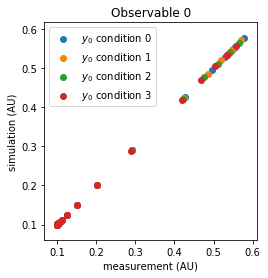

[0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046616
 0.4009638  0.40199105 0.4041061  0.40843806 0.41721488 0.43460507
 0.46753068 0.52445703 0.60713044 0.69376801 0.73500837 0.70439349
 0.62886747 0.5355812 ] [0.40001243 0.40002572 0.40005321 0.40011008 0.40022773 0.40047104
 0.40097389 0.40201189 0.4041491  0.40852647 0.41739539 0.43496854
 0.46824194 0.52577065 0.60929503 0.69670961 0.73839152 0.70825844
 0.63302877 0.53912894]
[0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046615
 0.40096376 0.40199086 0.40410531 0.40843473 0.41720084 0.43454691
 0.46729775 0.5235843  0.60424229 0.6861011  0.72067371 0.68526733
 0.60642    0.51180379] [0.40001243 0.40002571 0.40005321 0.40011008 0.40022773 0.40047103
 0.40097385 0.4020117  0.40414831 0.40852311 0.41738124 0.43490996
 0.46800742 0.52489239 0.60639146 0.68901538 0.72403439 0.68912724
 0.61056414 0.51525341]
[0.4000123  0.40002545 0.40005266 0.40010894 0.40022537 0.40046614
 0.40096372 0.40199068 0.40410453

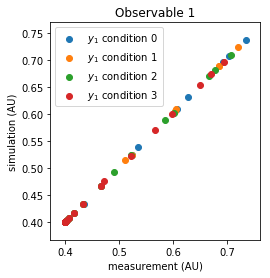

[0.6999792  0.69995696 0.69991095 0.69981577 0.69961885 0.6992116
 0.69836975 0.69663131 0.69304904 0.68569981 0.67075971 0.64095895
 0.58381563 0.4828983  0.33274096 0.17502923 0.08824506 0.06727818
 0.05651057 0.04468553] [0.6999791  0.69995675 0.6999105  0.69981483 0.69961692 0.69920759
 0.69836147 0.69661421 0.69301381 0.68562761 0.67061319 0.64066763
 0.58325981 0.48192074 0.33126267 0.17327792 0.08666848 0.06600666
 0.05553016 0.04391412]
[0.6999785  0.69995552 0.69990796 0.69980957 0.69960603 0.69918508
 0.69831495 0.6965182  0.69281623 0.68522334 0.66979577 0.63905514
 0.58023656 0.47681239 0.32424342 0.16659765 0.08234215 0.06252316
 0.05190231 0.04051998] [0.6999784  0.6999553  0.69990751 0.69980863 0.69960409 0.69918108
 0.69830667 0.69650111 0.69278102 0.68515118 0.66964946 0.63876466
 0.57968405 0.47584665 0.32280048 0.16492332 0.08087218 0.06136008
 0.05102327 0.03983143]
[0.6999778  0.69995407 0.69990496 0.69980337 0.6995932  0.69915856
 0.69826015 0.69640511 0.69258351 

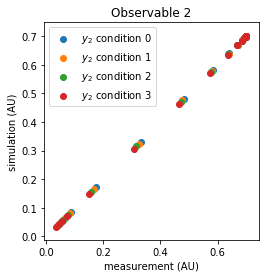

[0.2000356  0.20007366 0.20015241 0.20031533 0.2006524  0.20134958
 0.20279109 0.20576929 0.21191232 0.22454052 0.25031579 0.30212786
 0.4028219  0.58380281 0.8525968  1.1002188  1.15692673 1.11064669
 1.0570921  0.98989824] [0.19903553 0.19907346 0.19915196 0.19931438 0.19965037 0.20034535
 0.2017823  0.20475102 0.21087436 0.22346144 0.24915013 0.30077761
 0.40107439 0.58122586 0.8485773  1.09479892 1.15117049 1.10504914
 1.05204403 0.98499381]
[0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134956
 0.20279101 0.20576892 0.21191075 0.22453385 0.25028764 0.3020111
 0.40235471 0.58207915 0.84730771 1.08908853 1.14285653 1.09576545
 1.03970746 0.97057368] [0.19903553 0.19907346 0.19915196 0.19931437 0.19965037 0.20034533
 0.20178221 0.20475065 0.21087279 0.22345475 0.24912193 0.30066062
 0.40060641 0.57950003 0.84328445 1.08366642 1.13713337 1.0902739
 1.03479149 0.96575494]
[0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134954
 0.20279092 0.20576855 0.21190918 0

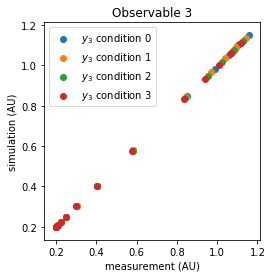

[3.4000123  3.40002545 3.40005266 3.40010894 3.40022538 3.40046616
 3.4009638  3.40199105 3.4041061  3.40843806 3.41721488 3.43460507
 3.46753068 3.52445703 3.60713044 3.69376801 3.73500837 3.70439349
 3.62886747 3.5355812 ] [3.39950827 3.39952155 3.39954905 3.39960592 3.39972357 3.39996688
 3.40046973 3.40150773 3.40364494 3.40802231 3.41689122 3.43446438
 3.46773778 3.52526649 3.60879086 3.69620545 3.73788736 3.70775427
 3.63252461 3.53862478]
[4.4000123  4.40002545 4.40005266 4.40010894 4.40022538 4.40046615
 4.40096376 4.40199086 4.40410531 4.40843473 4.41720084 4.43454691
 4.46729775 4.5235843  4.60424229 4.6861011  4.72067371 4.68526733
 4.60642    4.51180379] [4.37494662 4.37495991 4.3749874  4.37504428 4.37516193 4.37540522
 4.37590804 4.3769459  4.3790825  4.3834573  4.39231544 4.40984416
 4.44294161 4.49982659 4.58132566 4.66394958 4.69896859 4.66406144
 4.58549833 4.49018761]
[3.4000123  3.40002545 3.40005266 3.40010894 3.40022537 3.40046614
 3.40096372 3.40199068 3.40410453

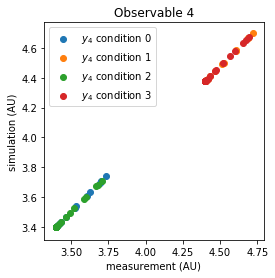

[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.12515789 0.15106393
 0.20141095 0.2919014  0.4262984  0.5501094  0.57846337 0.55532334
 0.52854605 0.49494912] [0.10001783 0.1000369  0.10007634 0.10015796 0.1003268  0.10067603
 0.10139812 0.10288994 0.10596699 0.11229216 0.12520105 0.1511445
 0.20154488 0.29207324 0.42642067 0.55015011 0.57847752 0.55530097
 0.52866524 0.49497167]
[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067478
 0.1013955  0.10288446 0.10595538 0.11226692 0.12514382 0.15100555
 0.20117735 0.29103957 0.42365386 0.54454426 0.57142826 0.54788272
 0.51985373 0.48528684] [0.10001783 0.1000369  0.10007634 0.10015796 0.1003268  0.10067602
 0.10139808 0.10288975 0.1059662  0.1122888  0.12518687 0.15108571
 0.20130972 0.29120599 0.42376095 0.54455589 0.57142369 0.54787622
 0.51999562 0.48530389]
[0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067477
 0.10139546 0.10288428 0.10595459 

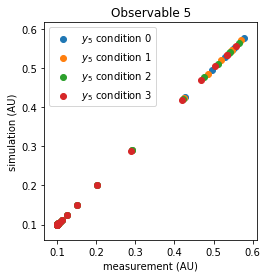

In [22]:
def plotCorrelation(ymes, ysim):
    for iy in range(ysim.shape[2]):
        fig, ax = plt.subplots()
        for icondition in range(ysim.shape[0]):
            x = ymes[icondition, :, iy]
            y = ysim[icondition, :, iy]
            print(x, y)
            ax.scatter(x, y, label='$y_%d$ condition %d' % (iy, icondition))
        plt.xlabel('measurement (AU)')
        plt.ylabel('simulation (AU)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Observable %d' % iy)
        plt.legend()
        plt.show()
        
plotCorrelation(ymes, ysim)

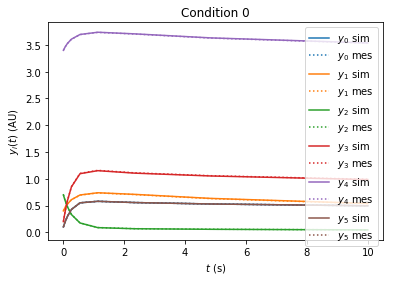

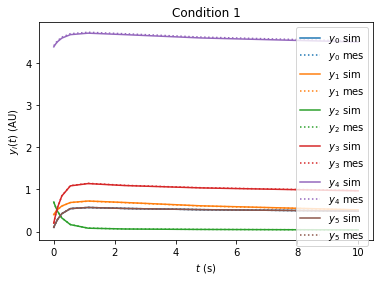

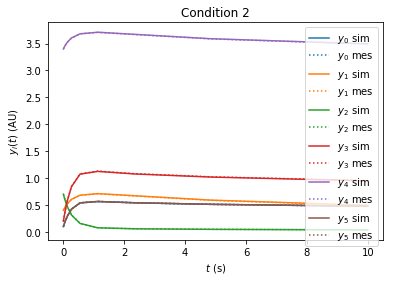

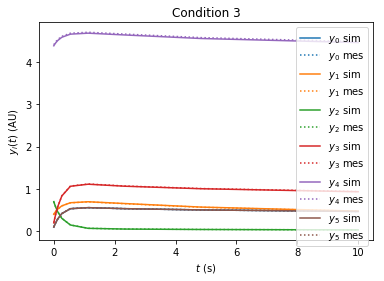

In [23]:
def plotTrajectoryFit(ymes, ysim, timepoints):
    for icondition in range(ysim.shape[0]):
        fig, ax = plt.subplots()
        for iy in range(ysim.shape[2]):
            ax.plot(timepoints, ysim[icondition, :, iy], label='$y_%d$ sim' % (iy), c='C%d'%iy)
            ax.plot(timepoints, ymes[icondition, :, iy], label='$y_%d$ mes' % (iy), linestyle='dotted', c='C%d'%iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.title('Condition %d' %icondition)
        plt.legend()
        plt.show()

plotTrajectoryFit(ymes, ysim, timepoints)

## Hierarchical optimization

In [24]:
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 1
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            1
                hierarchicalOptimization            1
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

In [25]:
# gradient check 
!PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deletemegc/ example_data.h5


HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-28 23:12:31] [ERR] [-1/]     0 g:     -12.4236  fd_c:      160.963  Δ/fd_c: -1.077183e+00  f:      2655.35
[2018-06-28 23:12:31] [WRN] [-1/]     1 g:     -860.101  fd_c:     -936.499  Δ/fd_c: -8.157839e-02  f:      2655.35
[2018-06-28 23:12:31] [ERR] [-1/]     2 g:      110.337  fd_c:      77.1432  Δ/fd_c: 4.302914e-01  f:      2655.35
[2018-06-28 23:12:31] [ERR] [-1/]     3 g:      1820.91  fd_c:      1530.88  Δ/fd_c: 1.894516e-01  f:      2655.35
[2018-06-28 23:12:31] [ERR] [-1/]     4 g:      3517.37  fd_c:      3152.04  Δ/fd_c: 1.159025e-01  f:      2655.35
[2018-06-28 23:12:31] [INF] [-1/] Walltime on master: 0.950054s, CPU time of all processes: 1.168973s


In [26]:
# optimization
!mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deletemehierarchical/ example_data.h5


[2018-06-28 23:12:31] [INF] [0/dweindl] Running with 4 MPI processes.
[2018-06-28 23:12:31] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2018-06-28 23:12:31] [DBG] [3/dweindl] Seeding RNG with 1530220351
[2018-06-28 23:12:31] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2018-06-28 23:12:31] [DBG] [2/dweindl] Seeding RNG with 1530220351
[2018-06-28 23:12:31] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2018-06-28 23:12:31] [DBG] [0/dweindl] Seeding RNG with 1530220351
[2018-06-28 23:12:31] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2018-06-28 23:12:31] [DBG] [1/dweindl] Seeding RNG with 1530220351
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-28 23:12:31] [DBG] [0/dweindl] Writing results to deletemehierarchical/_rank00000.h5.
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-28 23:12:31] [DBG] [3/dweindl] Writing results to deletemehierarchical/_ra

[2018-06-28 23:12:32] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -367.742 (0) (0.0217s)
[2018-06-28 23:12:32] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -351.333 (0) (0.0205s)
[2018-06-28 23:12:32] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -336.476 (0) (0.0360s)
[2018-06-28 23:12:32] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.94 (0) (0.0496s)
[2018-06-28 23:12:32] [INF] [0/dweindl] iter: 2 cost: 1378.49 time_iter: 0.239713s time_optim: 0.500598s
   2  1.3784905e+03 0.00e+00 1.52e-02  -5.5 2.65e-14    -  9.90e-01 1.00e+00f  1
[2018-06-28 23:12:32] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.83 (0) (0.0017s)
[2018-06-28 23:12:32] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0016s)
[2018-06-28 23:12:32] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.43 (0) (0.0016s)
[2018-06-28 23:12:32] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0017s)
[2018-06-28 23:12:32] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.83 (0) (0.0015s)
[2018-06-28 23:12:32] [DBG] [0/d

[2018-06-28 23:12:33] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -336.464 (0) (0.0250s)
[2018-06-28 23:12:33] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.928 (0) (0.0226s)
[2018-06-28 23:12:33] [INF] [0/dweindl] iter: 8 cost: 1378.44 time_iter: 0.155036s time_optim: 1.54329s
   8  1.3784444e+03 0.00e+00 3.41e-06 -10.6 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:33] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.83 (0) (0.0044s)
[2018-06-28 23:12:33] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0019s)
[2018-06-28 23:12:33] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.43 (0) (0.0016s)
[2018-06-28 23:12:33] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0016s)
[2018-06-28 23:12:33] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.83 (0) (0.0016s)
[2018-06-28 23:12:33] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0017s)
[2018-06-28 23:12:33] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.43 (0) (0.0043s)
[2018-06-28 23:12:33] [DBG] [0/d

[2018-06-28 23:12:34] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.83 (0) (0.0018s)
[2018-06-28 23:12:34] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0022s)
[2018-06-28 23:12:34] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.43 (0) (0.0019s)
[2018-06-28 23:12:34] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0031s)
[2018-06-28 23:12:34] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -367.728 (0) (0.0198s)
[2018-06-28 23:12:34] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -351.319 (0) (0.0222s)
[2018-06-28 23:12:34] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -336.462 (0) (0.0190s)
[2018-06-28 23:12:34] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.926 (0) (0.0257s)
[2018-06-28 23:12:34] [INF] [0/dweindl] iter: 15 cost: 1378.43 time_iter: 0.145647s time_optim: 2.79879s
  15  1.3784335e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:34] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.83 (0) (0.0016s)
[2018-06-28 23:12:34] [DBG] [0/

[2018-06-28 23:12:35] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.83 (0) (0.0015s)
[2018-06-28 23:12:35] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0017s)
[2018-06-28 23:12:35] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.43 (0) (0.0016s)
[2018-06-28 23:12:35] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0014s)
[2018-06-28 23:12:35] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -367.725 (0) (0.0226s)
[2018-06-28 23:12:35] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -351.316 (0) (0.0217s)
[2018-06-28 23:12:35] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -336.459 (0) (0.0222s)
[2018-06-28 23:12:35] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.923 (0) (0.0188s)
[2018-06-28 23:12:35] [INF] [0/dweindl] iter: 21 cost: 1378.42 time_iter: 0.14508s time_optim: 3.82334s
  21  1.3784241e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:35] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.83 (0) (0.0014s)
[2018-06-28 23:12:35] [DBG] [0/d

[2018-06-28 23:12:36] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.43 (0) (0.0015s)
[2018-06-28 23:12:36] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0033s)
[2018-06-28 23:12:36] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -367.723 (0) (0.0282s)
[2018-06-28 23:12:37] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -351.314 (0) (0.0471s)
[2018-06-28 23:12:37] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -336.457 (0) (0.0371s)
[2018-06-28 23:12:37] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.921 (0) (0.0349s)
[2018-06-28 23:12:37] [INF] [0/dweindl] iter: 27 cost: 1378.41 time_iter: 0.239971s time_optim: 5.19688s
  27  1.3784147e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:37] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.83 (0) (0.0033s)
[2018-06-28 23:12:37] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0135s)
[2018-06-28 23:12:37] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.43 (0) (0.0029s)
[2018-06-28 23:12:37] [DBG] [0/

[2018-06-28 23:12:38] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -367.72 (0) (0.0722s)
[2018-06-28 23:12:38] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -351.312 (0) (0.0194s)
[2018-06-28 23:12:38] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -336.455 (0) (0.0200s)
[2018-06-28 23:12:38] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.919 (0) (0.0182s)
[2018-06-28 23:12:38] [INF] [0/dweindl] iter: 33 cost: 1378.41 time_iter: 0.253648s time_optim: 6.42299s
  33  1.3784054e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:38] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.82 (0) (0.0021s)
[2018-06-28 23:12:38] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0039s)
[2018-06-28 23:12:38] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.42 (0) (0.0018s)
[2018-06-28 23:12:38] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0017s)
[2018-06-28 23:12:38] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.82 (0) (0.0016s)
[2018-06-28 23:12:38] [DBG] [0/d

[2018-06-28 23:12:39] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.916 (0) (0.0237s)
[2018-06-28 23:12:39] [INF] [0/dweindl] iter: 39 cost: 1378.4 time_iter: 0.117032s time_optim: 7.34773s
  39  1.3783960e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:39] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.82 (0) (0.0016s)
[2018-06-28 23:12:39] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0016s)
[2018-06-28 23:12:39] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.42 (0) (0.0017s)
[2018-06-28 23:12:39] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0016s)
[2018-06-28 23:12:39] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.82 (0) (0.0023s)
[2018-06-28 23:12:39] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0040s)
[2018-06-28 23:12:39] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.42 (0) (0.0020s)
[2018-06-28 23:12:39] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0016s)
[2018-06-28 23:12:39] [DBG] [0/d

[2018-06-28 23:12:40] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -351.306 (0) (0.0172s)
[2018-06-28 23:12:40] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -336.45 (0) (0.0179s)
[2018-06-28 23:12:40] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.914 (0) (0.0197s)
[2018-06-28 23:12:40] [INF] [0/dweindl] iter: 46 cost: 1378.39 time_iter: 0.116449s time_optim: 8.30068s
  46  1.3783851e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:40] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.82 (0) (0.0017s)
[2018-06-28 23:12:40] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0020s)
[2018-06-28 23:12:40] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.42 (0) (0.0018s)
[2018-06-28 23:12:40] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0016s)
[2018-06-28 23:12:40] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.82 (0) (0.0016s)
[2018-06-28 23:12:40] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0050s)
[2018-06-28 23:12:40] [DBG] [0/d

[2018-06-28 23:12:41] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.912 (0) (0.0291s)
[2018-06-28 23:12:41] [INF] [0/dweindl] iter: 52 cost: 1378.38 time_iter: 0.16193s time_optim: 9.22156s
  52  1.3783757e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:41] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.81 (0) (0.0016s)
[2018-06-28 23:12:41] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0016s)
[2018-06-28 23:12:41] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.42 (0) (0.0017s)
[2018-06-28 23:12:41] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0018s)
[2018-06-28 23:12:41] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.81 (0) (0.0015s)
[2018-06-28 23:12:41] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0031s)
[2018-06-28 23:12:41] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.42 (0) (0.0099s)
[2018-06-28 23:12:41] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0016s)
[2018-06-28 23:12:41] [DBG] [0/d

[2018-06-28 23:12:42] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0095s)
[2018-06-28 23:12:42] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.41 (0) (0.0016s)
[2018-06-28 23:12:42] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0016s)
[2018-06-28 23:12:42] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -367.71 (0) (0.0272s)
[2018-06-28 23:12:42] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -351.301 (0) (0.0301s)
[2018-06-28 23:12:42] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -336.445 (0) (0.0183s)
[2018-06-28 23:12:42] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.909 (0) (0.0232s)
[2018-06-28 23:12:42] [INF] [0/dweindl] iter: 59 cost: 1378.36 time_iter: 0.162809s time_optim: 10.2731s
  59  1.3783648e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:42] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.81 (0) (0.0016s)
[2018-06-28 23:12:42] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0022s)
[2018-06-28 23:12:42] [DBG] [0/d

[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -351.299 (0) (0.0221s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -336.442 (0) (0.0173s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.907 (0) (0.0232s)
[2018-06-28 23:12:43] [INF] [0/dweindl] iter: 65 cost: 1378.36 time_iter: 0.13998s time_optim: 11.256s
  65  1.3783555e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.81 (0) (0.0021s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0021s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.41 (0) (0.0017s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0016s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.81 (0) (0.0016s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0016s)
[2018-06-28 23:12:43] [DBG] [0/dw

[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.904 (0) (0.0182s)
[2018-06-28 23:12:43] [INF] [0/dweindl] iter: 71 cost: 1378.35 time_iter: 0.111707s time_optim: 11.9846s
  71  1.3783461e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.81 (0) (0.0015s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0015s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.41 (0) (0.0014s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0014s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.81 (0) (0.0015s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.9 (0) (0.0026s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.41 (0) (0.0014s)
[2018-06-28 23:12:43] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0014s)
[2018-06-28 23:12:43] [DBG] [0/

[2018-06-28 23:12:44] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -367.702 (0) (0.0380s)
[2018-06-28 23:12:45] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -351.294 (0) (0.0415s)
[2018-06-28 23:12:45] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -336.437 (0) (0.0568s)
[2018-06-28 23:12:45] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.902 (0) (0.0426s)
[2018-06-28 23:12:45] [INF] [0/dweindl] iter: 78 cost: 1378.34 time_iter: 0.280395s time_optim: 13.215s
  78  1.3783352e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:45] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.8 (0) (0.0025s)
[2018-06-28 23:12:45] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.8 (0) (0.0030s)
[2018-06-28 23:12:45] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.4 (0) (0.0033s)
[2018-06-28 23:12:45] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0030s)
[2018-06-28 23:12:45] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.8 (0) (0.0042s)
[2018-06-28 23:12:45] [DBG] [0/dwei

[2018-06-28 23:12:46] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -351.292 (0) (0.0152s)
[2018-06-28 23:12:46] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -336.435 (0) (0.0171s)
[2018-06-28 23:12:46] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.899 (0) (0.0191s)
[2018-06-28 23:12:46] [INF] [0/dweindl] iter: 84 cost: 1378.33 time_iter: 0.11875s time_optim: 14.1263s
  84  1.3783258e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:46] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.8 (0) (0.0031s)
[2018-06-28 23:12:46] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.8 (0) (0.0033s)
[2018-06-28 23:12:46] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.4 (0) (0.0026s)
[2018-06-28 23:12:46] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0027s)
[2018-06-28 23:12:46] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.8 (0) (0.0070s)
[2018-06-28 23:12:46] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.8 (0) (0.0034s)
[2018-06-28 23:12:46] [DBG] [0/dwei

[2018-06-28 23:12:47] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.897 (0) (0.0259s)
[2018-06-28 23:12:47] [INF] [0/dweindl] iter: 90 cost: 1378.32 time_iter: 0.167872s time_optim: 15.2564s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.3783165e+03 0.00e+00 3.41e-06 -12.3 3.41e-06    -  1.00e+00 1.00e+00f  1
[2018-06-28 23:12:47] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.8 (0) (0.0026s)
[2018-06-28 23:12:47] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.8 (0) (0.0025s)
[2018-06-28 23:12:47] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.4 (0) (0.0024s)
[2018-06-28 23:12:47] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0024s)
[2018-06-28 23:12:47] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.8 (0) (0.0024s)
[2018-06-28 23:12:47] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.8 (0) (0.0026s)
[2018-06-28 23:12:47] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.4 (0) (0.0024s)
[2018-06-28 23:12:47] [DBG] [0/dweindl] R

[2018-06-28 23:12:48] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.8 (0) (0.0049s)
[2018-06-28 23:12:48] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.4 (0) (0.0052s)
[2018-06-28 23:12:48] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0070s)
[2018-06-28 23:12:48] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9773.79 (0) (0.0078s)
[2018-06-28 23:12:48] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16872.8 (0) (0.0050s)
[2018-06-28 23:12:48] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9700.4 (0) (0.0084s)
[2018-06-28 23:12:48] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16791.3 (0) (0.0060s)
[2018-06-28 23:12:48] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -367.695 (0) (0.0661s)
[2018-06-28 23:12:48] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -351.286 (0) (0.0585s)
[2018-06-28 23:12:48] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -336.43 (0) (0.0623s)
[2018-06-28 23:12:49] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -322.895 (0) (0.0578s)
[2018-06-28 23:12:49] [INF] [0/dweindl] iter: 

In [27]:
filename = 'deletemehierarchical/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
trajectory

array([[3.21041948e+17, 1.37849051e+03, 1.37849051e+03, 1.37849051e+03,
        1.37849051e+03, 1.37844970e+03, 1.37844749e+03, 1.37844593e+03,
        1.37844437e+03, 1.37844281e+03, 1.37844125e+03, 1.37843969e+03,
        1.37843813e+03, 1.37843657e+03, 1.37843502e+03, 1.37843346e+03,
        1.37843190e+03, 1.37843034e+03, 1.37842878e+03, 1.37842722e+03,
        1.37842566e+03, 1.37842410e+03, 1.37842254e+03, 1.37842098e+03,
        1.37841942e+03, 1.37841786e+03, 1.37841630e+03, 1.37841474e+03,
        1.37841318e+03, 1.37841162e+03, 1.37841006e+03, 1.37840850e+03,
        1.37840694e+03, 1.37840538e+03, 1.37840382e+03, 1.37840226e+03,
        1.37840070e+03, 1.37839914e+03, 1.37839758e+03, 1.37839602e+03,
        1.37839446e+03, 1.37839290e+03, 1.37839134e+03, 1.37838978e+03,
        1.37838822e+03, 1.37838666e+03, 1.37838510e+03, 1.37838355e+03,
        1.37838199e+03, 1.37838043e+03, 1.37837887e+03, 1.37837730e+03,
        1.37837574e+03, 1.37837418e+03, 1.37837262e+03, 1.378371

In [28]:
compareResults('deletemehierarchical/_rank00000.h5', -expectedLlh)

#  __Exp___ __Act___ __Err____
0: 1.000000 30.516369 29.516369
1: 0.500000 1.555216 1.055216
2: 0.400000 0.006881 -0.393119
3: 2.000000 0.052179 -1.947821
4: 0.100000 0.035530 -0.064470
5: 2.000000 3.765417 1.765417
6: 3.000000 1171.769176 1168.769176
7: 0.200000 0.075235 -0.124765
8: 4.000000 11617.590739 11613.590739
Status: 1
Cost: 1378.300843 (expected: -608.698574)


In [29]:
!rm simh.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deletemehierarchical/_rank00000.h5 / simh.h5 / --at-optimum

Running for start 0
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma


In [30]:
with h5py.File('simh.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.12515789 0.15106393
 0.20141095 0.2919014  0.4262984  0.5501094  0.57846337 0.55532334
 0.52854605 0.49494912] [0.09999405 0.09998769 0.09997454 0.09994732 0.09989107 0.09977489
 0.0995354  0.09904376 0.09804279 0.09603894 0.09216008 0.08512186
 0.07375621 0.05857562 0.04311581 0.03188363 0.02584525 0.02256806
 0.02135563 0.02133757]
[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067478
 0.1013955  0.10288446 0.10595538 0.11226692 0.12514382 0.15100555
 0.20117735 0.29103957 0.42365386 0.54454426 0.57142826 0.54788272
 0.51985373 0.48528684] [0.09999405 0.09998769 0.09997454 0.09994732 0.09989107 0.09977489
 0.0995354  0.09904375 0.09804277 0.09603886 0.09215972 0.08512044
 0.07375081 0.05855639 0.04305398 0.03171865 0.02555424 0.02234055
 0.02131723 0.02133554]
[0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067477
 0.10139546 0.10288428 0.10595459

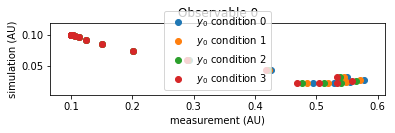

[0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046616
 0.4009638  0.40199105 0.4041061  0.40843806 0.41721488 0.43460507
 0.46753068 0.52445703 0.60713044 0.69376801 0.73500837 0.70439349
 0.62886747 0.5355812 ] [0.40000277 0.40000572 0.40001184 0.4000245  0.40005067 0.40010471
 0.40021614 0.40044498 0.40091129 0.40184649 0.40366406 0.40699358
 0.41250218 0.42036323 0.42995208 0.44053602 0.4509173  0.45637344
 0.45092471 0.43498953]
[0.4000123  0.40002545 0.40005266 0.40010894 0.40022538 0.40046615
 0.40096376 0.40199086 0.40410531 0.40843473 0.41720084 0.43454691
 0.46729775 0.5235843  0.60424229 0.6861011  0.72067371 0.68526733
 0.60642    0.51180379] [0.40000277 0.40000572 0.40001184 0.4000245  0.40005067 0.40010471
 0.40021614 0.40044498 0.40091127 0.4018464  0.40366368 0.40699193
 0.41249507 0.42033324 0.42983218 0.4401063  0.44965659 0.45376346
 0.44753502 0.43180191]
[0.4000123  0.40002545 0.40005266 0.40010894 0.40022537 0.40046614
 0.40096372 0.40199068 0.40410453

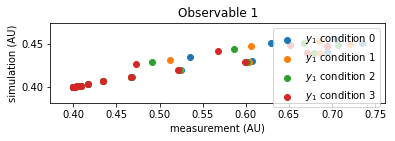

[0.6999792  0.69995696 0.69991095 0.69981577 0.69961885 0.6992116
 0.69836975 0.69663131 0.69304904 0.68569981 0.67075971 0.64095895
 0.58381563 0.4828983  0.33274096 0.17502923 0.08824506 0.06727818
 0.05651057 0.04468553] [0.69999326 0.69998605 0.69997113 0.69994027 0.69987641 0.69974428
 0.69947094 0.69890557 0.6977366  0.69532162 0.69034138 0.68011194
 0.65929541 0.61786151 0.53951006 0.40700554 0.22877321 0.0756415
 0.01884194 0.01381809]
[0.6999785  0.69995552 0.69990796 0.69980957 0.69960603 0.69918508
 0.69831495 0.6965182  0.69281623 0.68522334 0.66979577 0.63905514
 0.58023656 0.47681239 0.32424342 0.16659765 0.08234215 0.06252316
 0.05190231 0.04051998] [0.69999256 0.6999846  0.69996813 0.69993407 0.69986358 0.69971774
 0.69941605 0.6987921  0.69750225 0.69483855 0.68934968 0.67809315
 0.65525705 0.6100714  0.52557474 0.385682   0.20508707 0.06172684
 0.01575682 0.01250659]
[0.6999778  0.69995407 0.69990496 0.69980337 0.6995932  0.69915856
 0.69826015 0.69640511 0.69258351 0

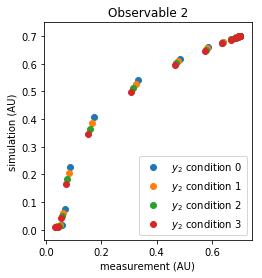

[0.2000356  0.20007366 0.20015241 0.20031533 0.2006524  0.20134958
 0.20279109 0.20576929 0.21191232 0.22454052 0.25031579 0.30212786
 0.4028219  0.58380281 0.8525968  1.1002188  1.15692673 1.11064669
 1.0570921  0.98989824] [0.37651935 0.3764954  0.37644586 0.3763434  0.37613158 0.37569411
 0.37479235 0.3729411  0.36917203 0.36162671 0.34702117 0.32051934
 0.27772294 0.22056165 0.16234902 0.12005519 0.09731815 0.08497818
 0.08041286 0.08034486]
[0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134956
 0.20279101 0.20576892 0.21191075 0.22453385 0.25028764 0.3020111
 0.40235471 0.58207915 0.84730771 1.08908853 1.14285653 1.09576545
 1.03970746 0.97057368] [0.37651935 0.3764954  0.37644586 0.3763434  0.37613158 0.37569411
 0.37479235 0.37294108 0.36917195 0.36162639 0.34701984 0.32051401
 0.27770258 0.22048927 0.16211623 0.11943396 0.09622238 0.0841215
 0.08026828 0.08033723]
[0.2000356  0.20007366 0.20015241 0.20031533 0.20065239 0.20134954
 0.20279092 0.20576855 0.21190918 0

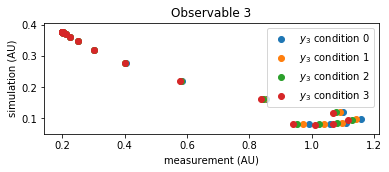

[3.4000123  3.40002545 3.40005266 3.40010894 3.40022538 3.40046616
 3.4009638  3.40199105 3.4041061  3.40843806 3.41721488 3.43460507
 3.46753068 3.52445703 3.60713044 3.69376801 3.73500837 3.70439349
 3.62886747 3.5355812 ] [3.46884484 3.46884779 3.46885391 3.46886657 3.46889274 3.46894678
 3.46905821 3.46928705 3.46975336 3.47068856 3.47250613 3.47583565
 3.48134425 3.4892053  3.49879415 3.50937808 3.51975937 3.52521551
 3.51976678 3.5038316 ]
[4.4000123  4.40002545 4.40005266 4.40010894 4.40022538 4.40046615
 4.40096376 4.40199086 4.40410531 4.40843473 4.41720084 4.43454691
 4.46729775 4.5235843  4.60424229 4.6861011  4.72067371 4.68526733
 4.60642    4.51180379] [4.46511884 4.4651218  4.46512792 4.46514057 4.46516674 4.46522079
 4.46533221 4.46556105 4.46602734 4.46696247 4.46877975 4.472108
 4.47761114 4.48544931 4.49494825 4.50522237 4.51477266 4.51887953
 4.51265109 4.49691798]
[3.4000123  3.40002545 3.40005266 3.40010894 3.40022537 3.40046614
 3.40096372 3.40199068 3.40410453 3

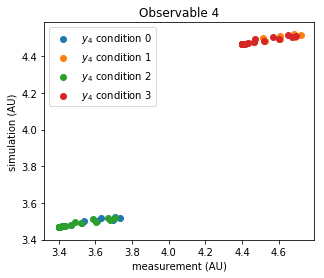

[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067479
 0.10139555 0.10288464 0.10595616 0.11227026 0.12515789 0.15106393
 0.20141095 0.2919014  0.4262984  0.5501094  0.57846337 0.55532334
 0.52854605 0.49494912] [0.09999405 0.09998769 0.09997454 0.09994732 0.09989107 0.09977489
 0.0995354  0.09904376 0.09804279 0.09603894 0.09216008 0.08512186
 0.07375621 0.05857562 0.04311581 0.03188363 0.02584525 0.02256806
 0.02135563 0.02133757]
[0.1000178  0.10003683 0.1000762  0.10015767 0.1003262  0.10067478
 0.1013955  0.10288446 0.10595538 0.11226692 0.12514382 0.15100555
 0.20117735 0.29103957 0.42365386 0.54454426 0.57142826 0.54788272
 0.51985373 0.48528684] [0.09999405 0.09998769 0.09997454 0.09994732 0.09989107 0.09977489
 0.0995354  0.09904375 0.09804277 0.09603886 0.09215972 0.08512044
 0.07375081 0.05855639 0.04305398 0.03171865 0.02555424 0.02234055
 0.02131723 0.02133554]
[0.1000178  0.10003683 0.1000762  0.10015767 0.10032619 0.10067477
 0.10139546 0.10288428 0.10595459

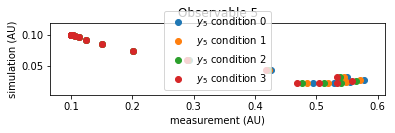

In [31]:
plotCorrelation(ymes, ysim)

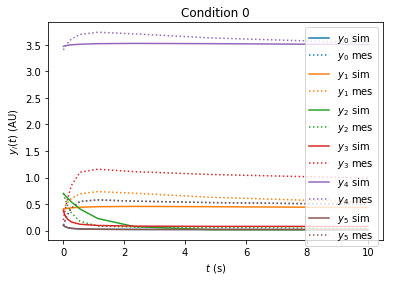

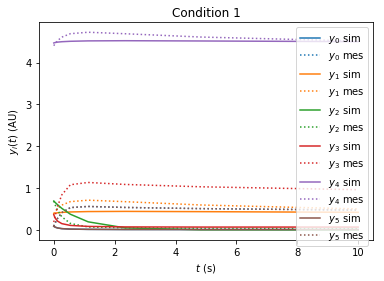

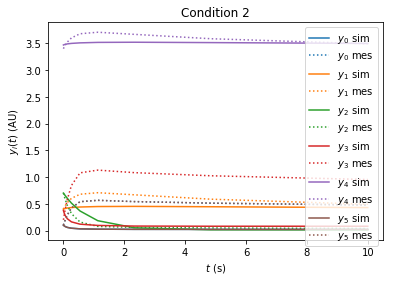

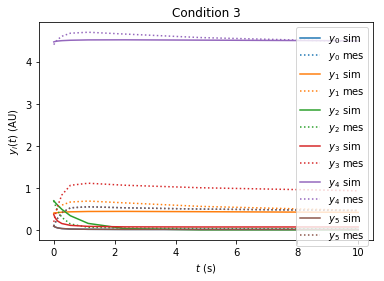

In [32]:
plotTrajectoryFit(ymes, ysim, timepoints)

## Ceres

In [33]:
!../../../misc/optimizationOptions.py example_data.h5 -s optimizer 1
!mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deletemeceres/ example_data.h5


[2018-06-28 23:12:57] [INF] [0/dweindl] Running with 4 MPI processes.
[2018-06-28 23:12:57] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2018-06-28 23:12:57] [DBG] [1/dweindl] Seeding RNG with 1530220377
[2018-06-28 23:12:57] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2018-06-28 23:12:57] [DBG] [3/dweindl] Seeding RNG with 1530220377
[2018-06-28 23:12:57] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2018-06-28 23:12:57] [DBG] [2/dweindl] Seeding RNG with 1530220377
[2018-06-28 23:12:57] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2018-06-28 23:12:57] [DBG] [0/dweindl] Seeding RNG with 1530220377
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-28 23:12:57] [DBG] [1/dweindl] Writing results to deletemeceres/_rank00001.h5.
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-28 23:12:57] [DBG] [3/dweindl] Writing results to deletemeceres/_rank00003.h5.
Hi

[2018-06-28 23:12:58] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -1.6957e+07 (0) (0.0196s)
[2018-06-28 23:12:58] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -1.65714e+07 (0) (0.0358s)
[2018-06-28 23:12:58] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -8976.37 (0) (0.0034s)
[2018-06-28 23:12:58] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -15974.2 (0) (0.0015s)
[2018-06-28 23:12:58] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -8972.16 (0) (0.0014s)
[2018-06-28 23:12:58] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -15970.3 (0) (0.0081s)
[2018-06-28 23:12:58] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -1.59992e+08 (0) (0.0442s)
[2018-06-28 23:12:58] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -1.56031e+08 (0) (0.0309s)
[2018-06-28 23:12:58] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -1.52336e+08 (0) (0.0387s)
[2018-06-28 23:12:58] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -1.48876e+08 (0) (0.0401s)
[2018-06-28 23:12:58] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -8976.16 (0) (0.0015s)
[2018-06-28 23:12:58

[2018-06-28 23:12:59] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -201.588 (0) (0.0306s)
[2018-06-28 23:12:59] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -195.96 (0) (0.0236s)
[2018-06-28 23:12:59] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -190.496 (0) (0.0145s)
[2018-06-28 23:12:59] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9579.87 (0) (0.0016s)
[2018-06-28 23:12:59] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16674.1 (0) (0.0017s)
[2018-06-28 23:12:59] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9528.03 (0) (0.0017s)
[2018-06-28 23:12:59] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16614.3 (0) (0.0016s)
[2018-06-28 23:12:59] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -207.302 (0) (0.0140s)
[2018-06-28 23:13:00] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -201.493 (0) (0.0145s)
[2018-06-28 23:13:00] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -195.843 (0) (0.0142s)
[2018-06-28 23:13:00] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -190.36 (0) (0.0144s)
[2018-06-28 23:13:00] [DBG] [0/dweindl] Resul

[2018-06-28 23:13:01] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -201.479 (0) (0.0141s)
[2018-06-28 23:13:01] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -195.827 (0) (0.0141s)
[2018-06-28 23:13:01] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -190.341 (0) (0.0175s)
[2018-06-28 23:13:01] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -9580.04 (0) (0.0066s)
[2018-06-28 23:13:01] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -16674.3 (0) (0.0040s)
[2018-06-28 23:13:01] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -9528.18 (0) (0.0034s)
[2018-06-28 23:13:01] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -16614.5 (0) (0.0032s)
[2018-06-28 23:13:01] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -207.288 (0) (0.0268s)
[2018-06-28 23:13:01] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -201.474 (0) (0.0283s)
[2018-06-28 23:13:01] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -195.82 (0) (0.0229s)
[2018-06-28 23:13:01] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -190.333 (0) (0.0149s)
[2018-06-28 23:13:01] [DBG] [0/dweindl] Resu

In [34]:
compareResults('deletemeceres/_rank00000.h5', -expectedLlh)

#  __Exp___ __Act___ __Err____
0: 1.000000 0.000015 -0.999985
1: 0.500000 0.000017 -0.499983
2: 0.400000 0.000051 -0.399949
3: 2.000000 0.175979 -1.824021
4: 0.100000 0.000990 -0.099010
5: 2.000000 4.356917 2.356917
6: 3.000000 1149.903671 1146.903671
7: 0.200000 0.037158 -0.162842
8: 4.000000 11420.354125 11416.354125
Status: 0
Cost: 794.911030 (expected: -608.698574)


# TODO

## preeequilibration
## different optimizers
## improve timing

In [35]:
list(model.getParameterNames())

['p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'scaling_x1',
 'offset_x2',
 'observable_x1withsigma_sigma']